In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Encoding breeds into integers

In [3]:
df["breed_coded"] = df.breed.astype('category').cat.codes

# Resizing images to (64, 64, 3), splitting into train/test ratio 9/1

In [4]:
import os
path_to_imgs = 'data/train'

batch_size = 32
img_height = 64
img_width = 64
dim = (img_width, img_height)


def func(id):
    img = cv2.imread(f'{path_to_imgs}/{id}.jpg', cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(df.id, df.breed_coded, 
                                                              test_size=0.1, random_state=42,
                                                             stratify=df.breed_coded)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [6]:
train_images = np.array([func(id) for id in X_train])
test_images = np.array([func(id) for id in X_test])

# Encoding labels into 1/0

In [7]:
y_binary_train = keras.utils.to_categorical(train_labels)
y_binary_test = keras.utils.to_categorical(test_labels)

# Loading VGG16 model

In [8]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',  # Load weights pre-trained on VGG16
    include_top=False)

# Freezing the model

In [9]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [10]:
x = base_model.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
# and a logistic layer -- with 120 classes
predictions = keras.layers.Dense(120, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Model training

In [11]:
EPOCHS = 16
history = model.fit(
    train_images, y_binary_train, epochs=EPOCHS
)

Train on 9199 samples
Epoch 1/16
9199/9199 [==============================] - 162s 18ms/sample - loss: 4.4942 - accuracy: 0.0577
Epoch 2/16
9199/9199 [==============================] - 161s 18ms/sample - loss: 3.6786 - accuracy: 0.1806
Epoch 3/16
9199/9199 [==============================] - 157s 17ms/sample - loss: 3.2705 - accuracy: 0.2582
Epoch 4/16
9199/9199 [==============================] - 158s 17ms/sample - loss: 2.9988 - accuracy: 0.3196
Epoch 5/16
9199/9199 [==============================] - 162s 18ms/sample - loss: 2.7860 - accuracy: 0.3661
Epoch 6/16
9199/9199 [==============================] - 163s 18ms/sample - loss: 2.6004 - accuracy: 0.4080
Epoch 7/16
9199/9199 [==============================] - 161s 18ms/sample - loss: 2.4748 - accuracy: 0.4272
Epoch 8/16
9199/9199 [==============================] - 161s 17ms/sample - loss: 2.3519 - accuracy: 0.4578
Epoch 9/16
9199/9199 [==============================] - 162s 18ms/sample - loss: 2.2380 - accuracy: 0.4855
Epoch 10/16
919

# Some vizualization

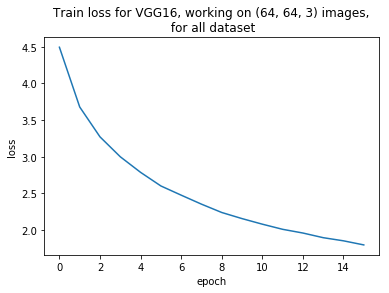

In [12]:
plt.plot(history.history['loss'])
plt.title('Train loss for VGG16, working on (64, 64, 3) images,\n for all dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/VGG16_64x64forALLLoss.png", dpi=300)
plt.show()

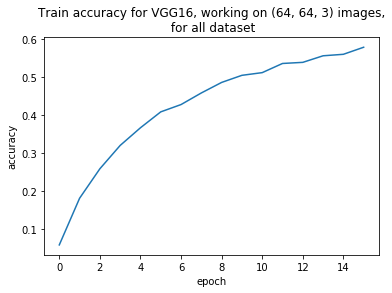

In [13]:
plt.plot(history.history['accuracy'])
plt.title('Train accuracy for VGG16, working on (64, 64, 3) images,\n for all dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/VGG16_64x64forALLAccuracy.png", dpi=300)
plt.show()

# Evaluation on the test images

In [14]:
results = model.evaluate(test_images, y_binary_test, batch_size=batch_size)
print("test loss, test acc:", results)

1023/1023 [==============================] - 18s 17ms/sample - loss: 4.5026 - accuracy: 0.1388
test loss, test acc: [4.502567322955686, 0.13880743]


In [15]:
res_df = pd.read_csv('results.csv')
res_df.drop(columns=["Unnamed: 0"], inplace=True)
res_df

,ModelDescription,TestAccuracy,TestLoss
0,"Fine-tuned AlexNet, Normalized, 150 Epochs, No...",0.104348,190.116042
1,"Fine-tuned ResNet50 on 50 epochs, with input i...",0.365217,5.512277
2,"Fine-tuned VGG16 on 20 epochs, with input imag...",0.626087,1.071098
3,"ResNet50 on 16 epochs, with input images of sh...",0.089932,11.383548


In [16]:
res_df = res_df.append(pd.DataFrame({
    "TestAccuracy": [results[1]],
    "TestLoss": [results[0]],
    "ModelDescription": ["Fine-tuned VGG16 on 16 epochs, with input images of shape (64, 64, 3) for all dataset"]
}))
res_df

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ModelDescription,TestAccuracy,TestLoss
0,"Fine-tuned AlexNet, Normalized, 150 Epochs, No...",0.104348,190.116042
1,"Fine-tuned ResNet50 on 50 epochs, with input i...",0.365217,5.512277
2,"Fine-tuned VGG16 on 20 epochs, with input imag...",0.626087,1.071098
3,"ResNet50 on 16 epochs, with input images of sh...",0.089932,11.383548
0,"Fine-tuned VGG16 on 16 epochs, with input imag...",0.138807,4.502567


In [17]:
res_df.to_csv('results.csv')